*LAB 03*

Variational Autoencoders

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 0.0213 - val_loss: 0.0099
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0093 - val_loss: 0.0087
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0085 - val_loss: 0.0083
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0081 - val_loss: 0.0077
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0075 - val_loss: 0.0073
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0074 - val_loss: 0.0072
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 9/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0071 - val_loss: 0.0069
Epoch 10/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0069 - val_loss: 0.0068


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1, Loss: 637.1834716796875
Epoch 2, Loss: 628.9033203125
Epoch 3, Loss: 628.322509765625
Epoch 4, Loss: 625.6166381835938
Epoch 5, Loss: 626.0684814453125
Epoch 6, Loss: 625.5278930664062
Epoch 7, Loss: 625.3136596679688
Epoch 8, Loss: 625.4212036132812
Epoch 9, Loss: 624.5589599609375
Epoch 10, Loss: 625.3910522460938
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


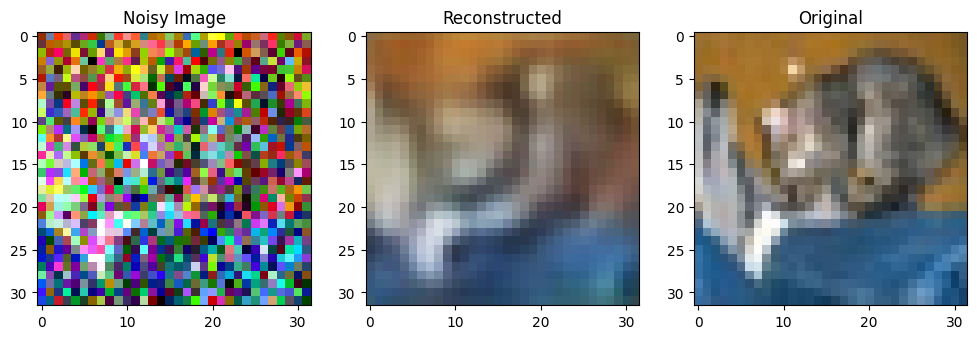

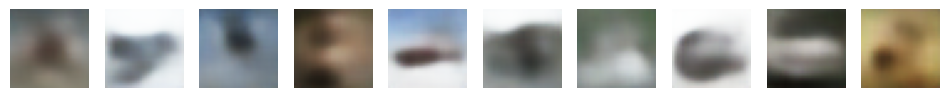

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10

# Load CIFAR-10 and normalize
(x_train, _), (x_test, _) = cifar10.load_data()
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

# Add noise
def add_noise(x, noise_factor=0.3):
    return np.clip(x + noise_factor * np.random.normal(size=x.shape), 0., 1.)

x_train_noisy, x_test_noisy = add_noise(x_train), add_noise(x_test)

# Denoising Autoencoder Model
def build_dae():
    input_img = layers.Input(shape=(32, 32, 3))
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

    autoencoder = models.Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    return autoencoder

# Train Denoising Autoencoder
dae = build_dae()
dae.fit(x_train_noisy, x_train, epochs=10, batch_size=128, validation_data=(x_test_noisy, x_test))

# VAE Model
class VAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
            layers.MaxPooling2D((2, 2), padding='same'),
            layers.Flatten(),
            layers.Dense(latent_dim + latent_dim)
        ])
        self.decoder = models.Sequential([
            layers.Dense(8 * 8 * 64, activation='relu', input_dim=latent_dim),
            layers.Reshape((8, 8, 64)),
            layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same'),
            layers.UpSampling2D((2, 2)),
            layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        z = self.encoder(x)
        mu, log_var = z[:, :self.latent_dim], z[:, self.latent_dim:]
        z = mu + tf.exp(0.5 * log_var) * tf.random.normal(tf.shape(mu))
        return self.decoder(z), mu, log_var

# VAE Loss Function
def vae_loss(x, x_decoded_mean, mu, log_var):
    reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(x, x_decoded_mean), axis=(1, 2)))
    kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + log_var - tf.square(mu) - tf.exp(log_var), axis=1))
    return reconstruction_loss + kl_loss

# Custom training loop for VAE (as it's easier to handle multiple outputs)
vae = VAE(latent_dim=64)

@tf.function
def compute_loss(model, x):
    # Forward pass
    decoded, mu, log_var = model(x)
    # Compute the loss
    loss = vae_loss(x, decoded, mu, log_var)
    return loss

# Train VAE
optimizer = tf.keras.optimizers.Adam()
for epoch in range(10):
    for batch in range(0, len(x_train), 128):
        x_batch = x_train[batch:batch+128]

        with tf.GradientTape() as tape:
            loss = compute_loss(vae, x_batch)

        grads = tape.gradient(loss, vae.trainable_variables)
        optimizer.apply_gradients(zip(grads, vae.trainable_variables))

    print(f"Epoch {epoch + 1}, Loss: {loss.numpy()}")

# Visualize Denoising Autoencoder results
def plot_images(noisy, reconstructed, original, idx=0):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1), plt.imshow(noisy[idx]), plt.title("Noisy Image")
    plt.subplot(1, 3, 2), plt.imshow(reconstructed[idx]), plt.title("Reconstructed")
    plt.subplot(1, 3, 3), plt.imshow(original[idx]), plt.title("Original")
    plt.show()

# Reconstructed images from Denoising Autoencoder
reconstructed_images = dae.predict(x_test_noisy)
plot_images(x_test_noisy, reconstructed_images, x_test)

# Generate and visualize new images from VAE
def generate_images(vae, num_images=10):
    random_latent_vectors = tf.random.normal(shape=(num_images, 64))
    return vae.decoder(random_latent_vectors).numpy()

generated_images = generate_images(vae)
plt.figure(figsize=(12, 12))
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(generated_images[i])
    plt.axis('off')
plt.show()
